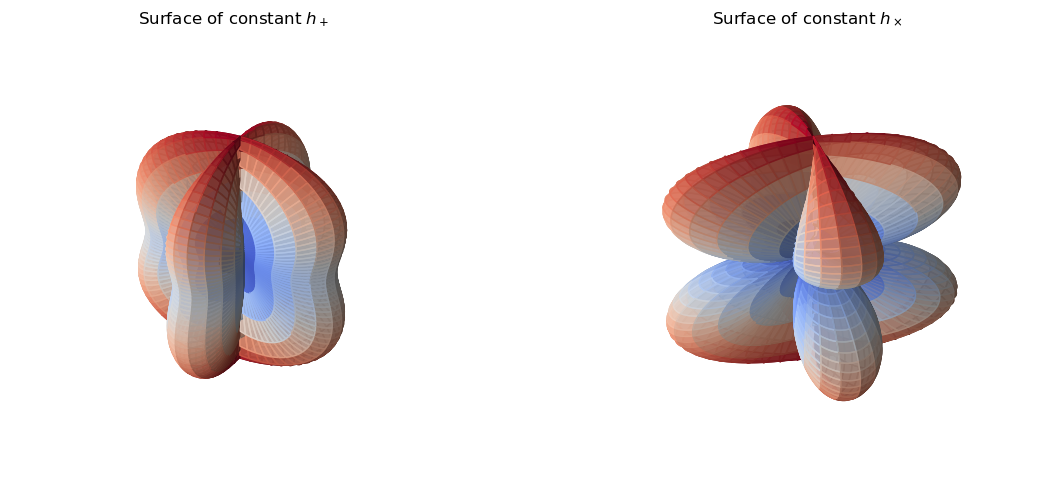

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Angles
theta = np.linspace(0, np.pi, 500)
phi = np.linspace(0, 2*np.pi, 500)
theta, phi = np.meshgrid(theta, phi)

# GW amplitude patterns for circular orbit
h0 = 1  # arbitrary units
h_plus = -h0 * (1 + np.cos(theta)**2)/2 * np.cos(2*phi)
h_cross = -2 * h0 * np.cos(theta) * np.sin(2*phi)

# Convert to spherical coordinates for plotting
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

# Plot h+
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection='3d')
r1 = np.abs(h_plus)
x1, y1, z1 = spherical_to_cartesian(r1, theta, phi)
ax1.plot_surface(x1, y1, z1, facecolors=plt.cm.coolwarm((r1 - r1.min()) / (r1.ptp())), alpha=0.8)
ax1.set_title('Surface of constant $h_+$')
ax1.set_box_aspect([1,1,1])

# Plot h_cross
ax2 = fig.add_subplot(122, projection='3d')
r2 = np.abs(h_cross)
x2, y2, z2 = spherical_to_cartesian(r2, theta, phi)
ax2.plot_surface(x2, y2, z2, facecolors=plt.cm.coolwarm((r2 - r2.min()) / (r2.ptp())), alpha=0.8)
ax2.set_title('Surface of constant $h_\\times$')
ax2.set_box_aspect([1,1,1])

for ax in [ax1, ax2]:
    ax.axis('off')

plt.tight_layout()
plt.show()


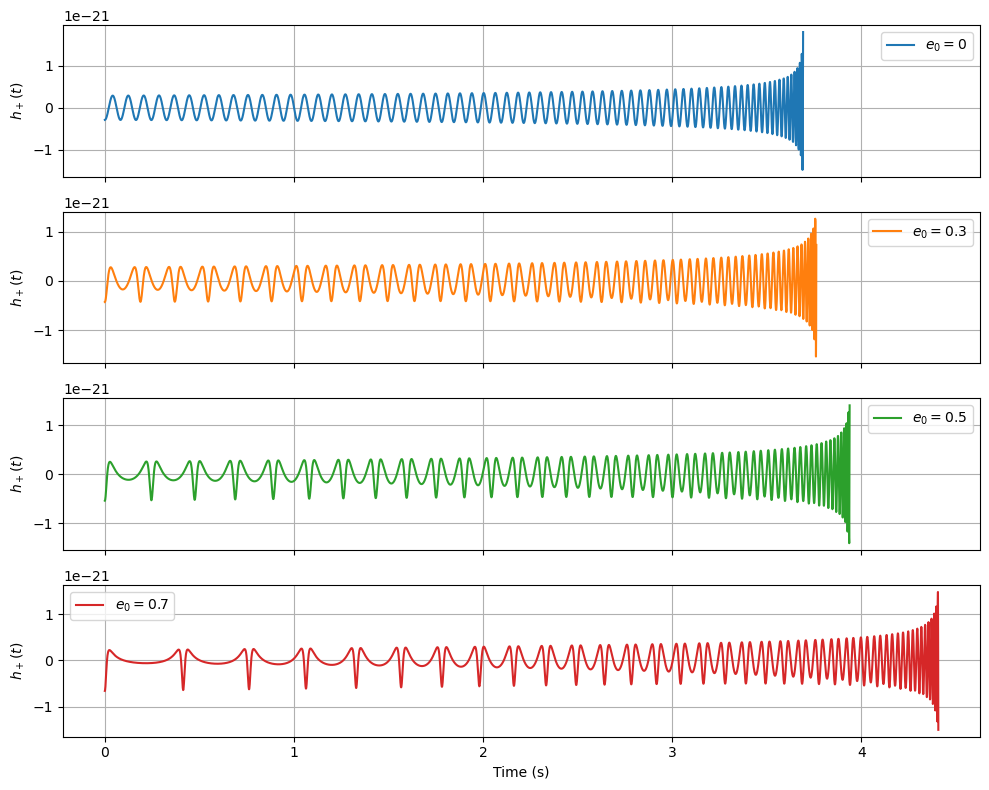

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
G = 6.67430e-11
c = 299792458
m1 = 30 * 1.9885e30
m2 = 30 * 1.9885e30
m = m1 + m2
nu = (m1 * m2) / m**2
R = 500e6 * 3.086e16
p0 = 20 * G * m / c**2
p_isco = 3 * G * m / c**2

def dpdt(t, p, e):
    return -(64/5) * nu * c * (G * m / (c**2 * p))**3 * (1 - e**2)**1.5 * (1 + (7/8) * e**2)

def dedt(t, p, e):
    dot_e = -(304/15) * nu * c * e / p * (G * m / (c**2 * p))**3 * (1 - e**2)**1.5 * (1 + (121/304) * e**2)
    return 3*dot_e

def dpsidt(t, psi, p, e):
    return np.sqrt(G * m / p**3) * (1 + e * np.cos(psi))**2

def h_plus(t, psi, e, h0):
    return -h0 * (2 * np.cos(2 * psi) + e * np.cos(psi) + 2 * e * np.cos(psi)**3 + e**2)

def solve_system(e0, t_max, dt):
    def odes(t, y):
        p, e, psi = y
        return [dpdt(t, p, e), dedt(t, p, e), dpsidt(t, psi, p, e)]

    def isco_reached(t, y):
        return y[0] - p_isco
    isco_reached.terminal = True
    isco_reached.direction = -1

    y0 = [p0, e0, 0]
    t_span = (0, t_max)
    t_eval = np.arange(0, t_max, dt)
    sol = solve_ivp(odes, t_span, y0, t_eval=t_eval, events=isco_reached, rtol=1e-9, atol=1e-9)

    p_sol, e_sol, psi_sol = sol.y
    h0 = 2 * G**2 * m1 * m2 / (c**4 * R * p_sol)
    hplus = h_plus(sol.t, psi_sol, e_sol, h0)

    return sol.t, hplus

# Plotting
e0_list = [0, 0.3, 0.5, 0.7]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, axs = plt.subplots(len(e0_list), 1, figsize=(10, 8), sharex=True)

for ax, e0, color in zip(axs, e0_list, colors):
    t, hplus = solve_system(e0, t_max=400, dt=0.001)
    ax.plot(t, hplus, color=color, label=f'$e_0 = {e0}$')
    ax.set_ylabel(r'$h_+(t)$')
    ax.legend()
    ax.grid(True)

axs[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()


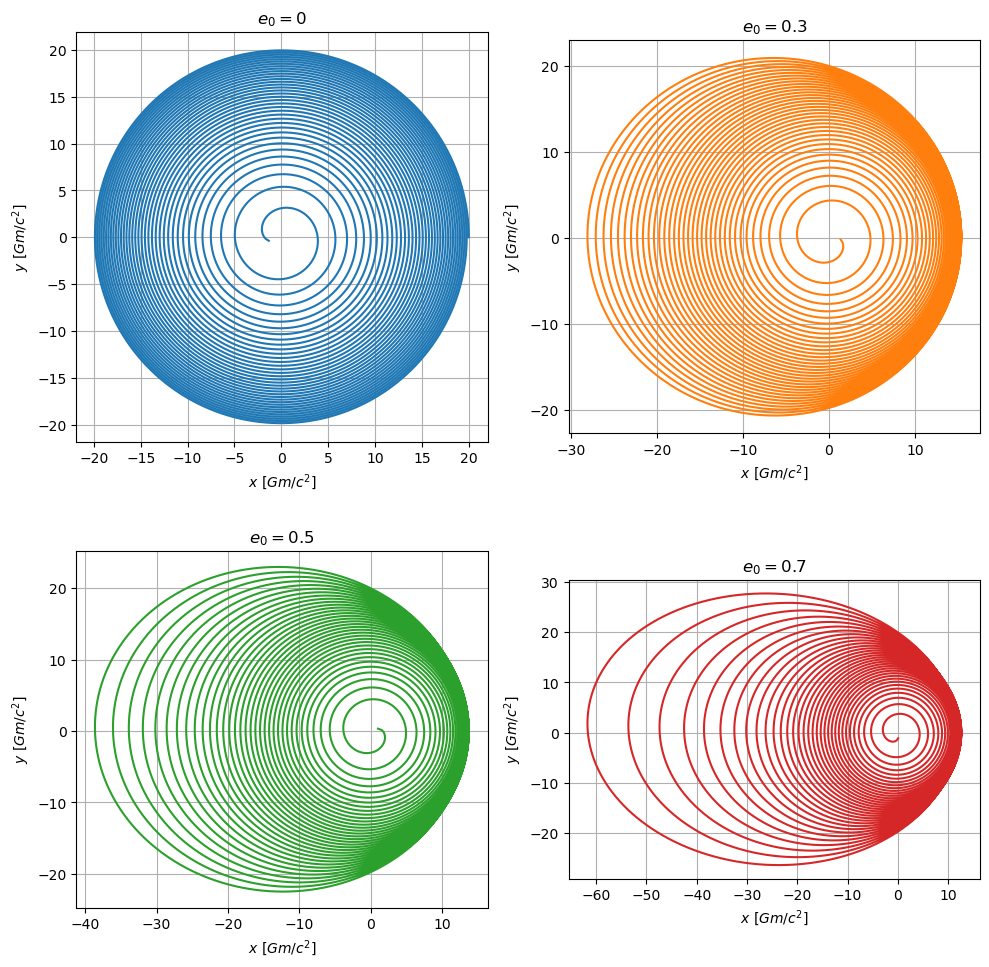

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
G = 6.67430e-11
c = 299792458
m1 = 30 * 1.9885e30
m2 = 30 * 1.9885e30
m = m1 + m2
nu = (m1 * m2) / m**2
p0 = 20 * G * m / c**2
p_isco = 0 * 2 * G * m / c**2

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

def dpdt(t, p, e):
    return -(64/5) * nu * c * (G * m / (c**2 * p))**3 * (1 - e**2)**1.5 * (1 + (7/8) * e**2)

def dedt(t, p, e):
    return -3*(304/15) * nu * c * e / p * (G * m / (c**2 * p))**3 * (1 - e**2)**1.5 * (1 + (121/304) * e**2)

def dpsidt(t, psi, p, e):
    return np.sqrt(G * m / p**3) * (1 + e * np.cos(psi))**2

def solve_orbit(e0, t_max, dt):
    def odes(t, y):
        p, e, psi = y
        return [dpdt(t, p, e), dedt(t, p, e), dpsidt(t, psi, p, e)]

    def isco_event(t, y):
        return y[0] - p_isco
    isco_event.terminal = True
    isco_event.direction = -1

    y0 = [p0, e0, 0]
    t_eval = np.arange(0, t_max, dt)
    sol = solve_ivp(odes, (0, t_max), y0, t_eval=t_eval, events=isco_event, rtol=1e-9, atol=1e-9)

    p_sol, e_sol, psi_sol = sol.y
    r_sol = p_sol / (1 + e_sol * np.cos(psi_sol))
    x_sol = r_sol * np.cos(psi_sol)
    y_sol = r_sol * np.sin(psi_sol)
    return x_sol, y_sol

# Plotting
e0_list = [0, 0.3, 0.5, 0.7]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for ax, e0, color in zip(axs.flatten(), e0_list, colors):
    x, y = solve_orbit(e0, t_max=200, dt=0.0001)
    ax.plot(x / (G * m / c**2), y / (G * m / c**2), color=color)
    ax.set_title(f'$e_0 = {e0}$')
    ax.set_xlabel(r'$x~[Gm/c^2]$')
    ax.set_ylabel(r'$y~[Gm/c^2]$')
    ax.set_aspect('equal')
    ax.grid(True)

plt.tight_layout()
plt.show()


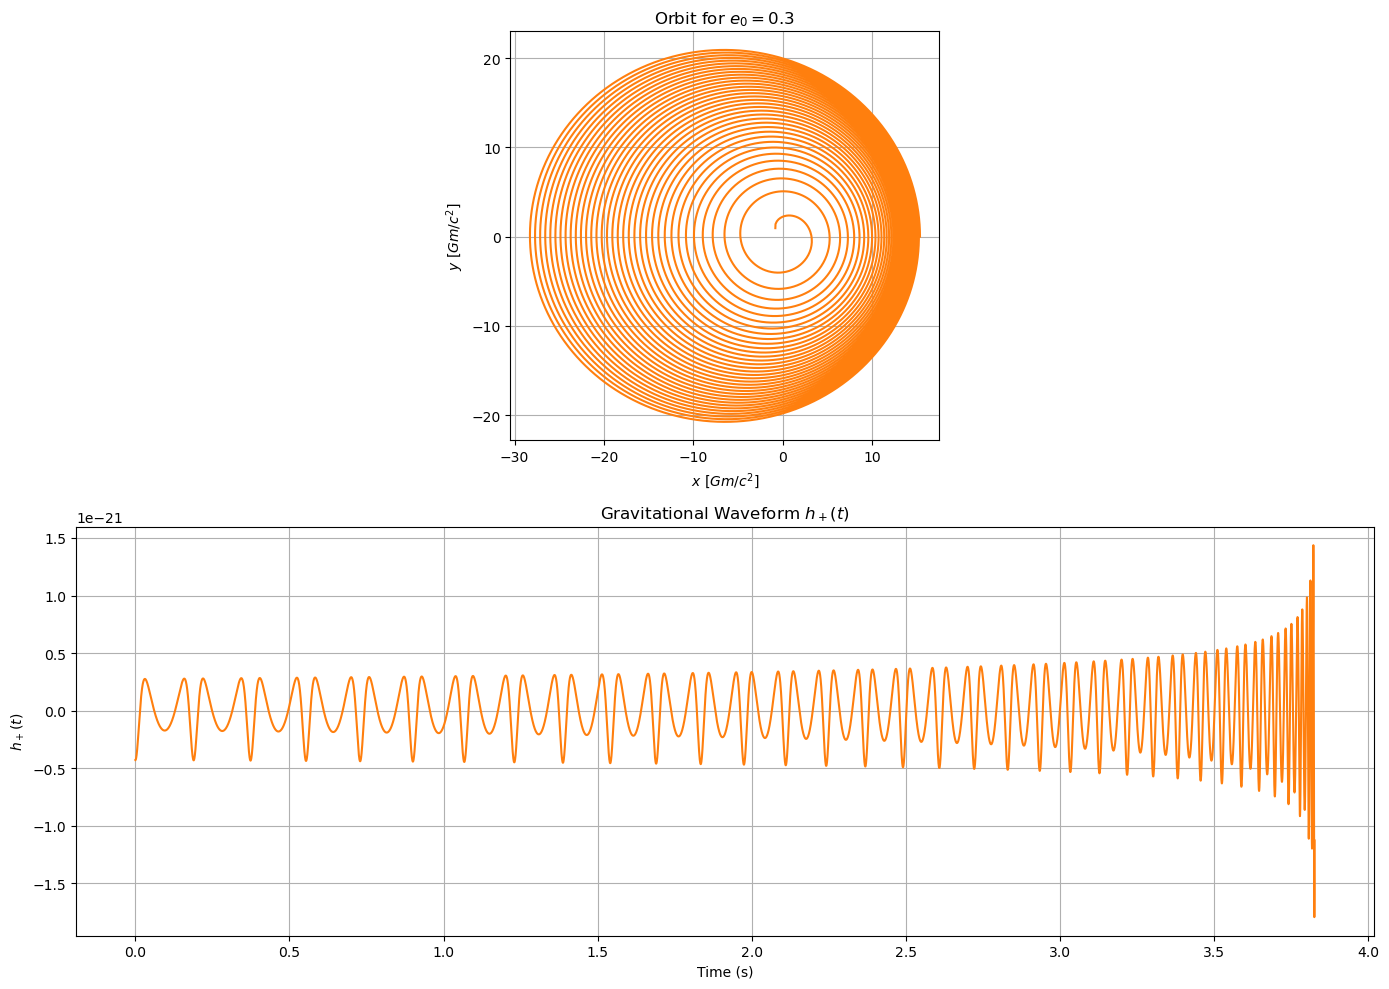

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
G = 6.67430e-11
c = 299792458
m1 = 30 * 1.9885e30
m2 = 30 * 1.9885e30
m = m1 + m2
nu = (m1 * m2) / m**2
R = 500e6 * 3.086e16  # Distance in meters
p0 = 20 * G * m / c**2
p_isco_wave = 3 * G * m / c**2
p_isco_orbit = 0*p_isco_wave

color = 'tab:orange'

def dpdt(t, p, e):
    return -(64/5) * nu * c * (G * m / (c**2 * p))**3 * (1 - e**2)**1.5 * (1 + (7/8) * e**2)

def dedt(t, p, e):
    dot_e = -(304/15) * nu * c * e / p * (G * m / (c**2 * p))**3 * (1 - e**2)**1.5 * (1 + (121/304) * e**2)
    return 1 * dot_e

def dpsidt(t, psi, p, e):
    return np.sqrt(G * m / p**3) * (1 + e * np.cos(psi))**2

def h_plus(t, psi, e, h0):
    return -h0 * (2 * np.cos(2 * psi) + e * np.cos(psi) + 2 * e * np.cos(psi)**3 + e**2)

def solve_with_isco(e0, t_max, dt, p_isco_stop):
    def odes(t, y):
        p, e, psi = y
        return [dpdt(t, p, e), dedt(t, p, e), dpsidt(t, psi, p, e)]

    def isco_event(t, y):
        return y[0] - p_isco_stop
    isco_event.terminal = True
    isco_event.direction = -1

    y0 = [p0, e0, 0]
    t_eval = np.arange(0, t_max, dt)
    sol = solve_ivp(odes, (0, t_max), y0, t_eval=t_eval, events=isco_event, rtol=1e-9, atol=1e-9)
    return sol

# Parameters
e0 = 0.3
t_max = 400
dt = 0.0001

# Solve for orbit (stop at p_isco_orbit)
sol_orbit = solve_with_isco(e0, t_max, dt, p_isco_orbit)
p_orb, e_orb, psi_orb = sol_orbit.y
t_orb = sol_orbit.t
r_orb = p_orb / (1 + e_orb * np.cos(psi_orb))
x_orb = r_orb * np.cos(psi_orb)
y_orb = r_orb * np.sin(psi_orb)

# Solve for waveform (stop at p_isco_wave)
sol_wave = solve_with_isco(e0, t_max, dt, p_isco_wave)
p_wave, e_wave, psi_wave = sol_wave.y
t_wave = sol_wave.t
h0_wave = 2 * G**2 * m1 * m2 / (c**4 * R * p_wave)
hplus = h_plus(t_wave, psi_wave, e_wave, h0_wave)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})

# Orbit plot
axs[0].plot(x_orb / (G * m / c**2), y_orb / (G * m / c**2), color=color)
axs[0].set_title(f'Orbit for $e_0 = {e0}$')
axs[0].set_xlabel(r'$x~[Gm/c^2]$')
axs[0].set_ylabel(r'$y~[Gm/c^2]$')
axs[0].set_aspect('equal')
axs[0].grid(True)

# Waveform plot
axs[1].plot(t_wave, hplus, color=color)
axs[1].set_title(r'Gravitational Waveform $h_+(t)$')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel(r'$h_+(t)$')
axs[1].grid(True)

plt.tight_layout()
plt.show()
